# Курсовой проект "Предсказание стоимости квартиры в Москве"

## 1. Импорт библиотек и загрузка данных

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import RidgeCV, Lasso, Ridge
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, VotingRegressor, BaggingRegressor, \
GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.linear_model import LinearRegression

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile


%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
matplotlib.rcParams.update({'font.size': 10})

In [3]:
import warnings
warnings.filterwarnings('ignore')

Подключаем KaggleAPI

In [4]:
#api = KaggleApi()
#api.authenticate()
#api.competition_download_files('real-estate-price-prediction-moscow')

Распаковываем архив с данными

In [5]:
dataset_zip = zipfile.ZipFile('./real-estate-price-prediction-moscow.zip')
dataset_zip.extractall()

Прописываем пути к данным

In [6]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'
SAMPLE_SUBMISSION_DATASET_PATH = './sample_submission.csv'

In [7]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(10,6))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Загружаем данные

In [8]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, encoding='utf-8')
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [9]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [10]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте:', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте: 5000


In [11]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

Приводим часть числовых значений к строковым

In [12]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

Оптимизация занимаемого пространства

In [13]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [14]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.89 MB
Decreased by 41.9%


## 2.EDA

In [15]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [16]:
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.453125
9996,16265,27,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.156250
9997,2795,178,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.906250
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.406250


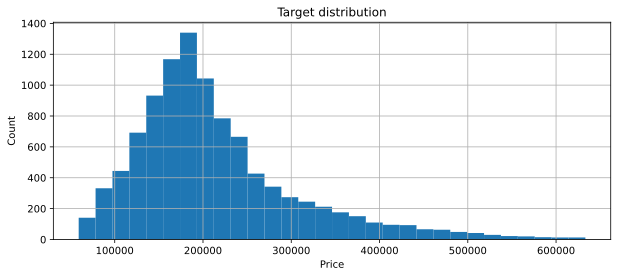

In [17]:
plt.figure(figsize = (10, 4))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

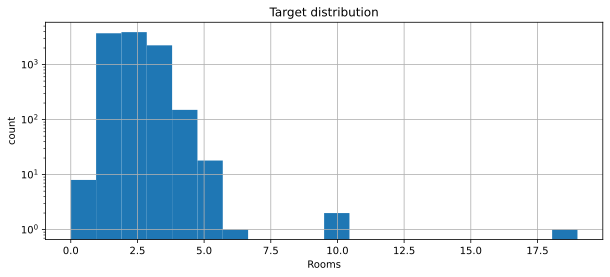

In [18]:
plt.figure(figsize = (10, 4))

train_df['Rooms'].hist(bins=20)
plt.ylabel('count')
plt.xlabel('Rooms')
plt.yscale(value="log")

plt.title('Target distribution')
plt.show()

In [19]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [20]:
#grid = sns.jointplot(train_df['Rooms'], train_df['LifeSquare'], kind='reg')
#grid.fig.set_figwidth(6)
#grid.fig.set_figheight(6)

#plt.show()

In [21]:
#grid = sns.jointplot(train_df['Rooms'], train_df['Square'], kind='reg')
#grid.fig.set_figwidth(8)
#grid.fig.set_figheight(8)

#plt.show()

In [22]:
#grid = sns.jointplot(train_df['LifeSquare'], train_df['Square'], kind='reg')
#grid.fig.set_figwidth(8)
#grid.fig.set_figheight(8)

#plt.show()

In [23]:
train_df.loc[train_df['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2194,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.109375
3780,7317,27,0.0,41.790882,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976562
5894,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.343750
6401,9443,27,0.0,87.762619,85.125473,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.921875
7644,7917,27,0.0,212.932358,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.250000
7929,456,6,0.0,81.491447,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.796875
9767,12638,27,0.0,138.427689,136.215500,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.750000
9869,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.945312


In [24]:
df_num_features = train_df.select_dtypes(include=['float64', 'float32', 'float16'])

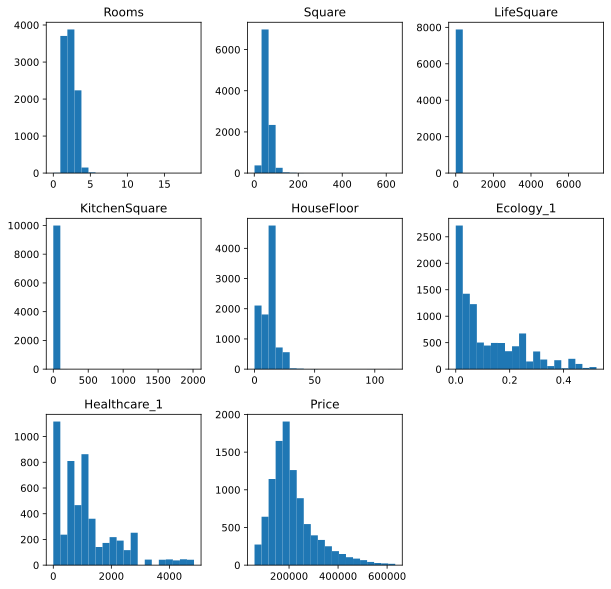

In [25]:
df_num_features.hist(figsize=(10,10), bins=20, grid=False);

### Обработка выбросов

In [26]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [27]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.875000,0
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.546875,0
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.718750,0
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.000000,0
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.093750,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,...,B,52,10311,6,NaN,1,9,B,119367.453125,0
9996,16265,27,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,...,B,2,629,1,NaN,0,0,A,199715.156250,0
9997,2795,178,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,...,B,20,4386,14,NaN,1,5,B,165953.906250,0
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,...,B,47,8004,3,125.0,3,5,B,171842.406250,0


In [28]:
rooms_quantity = pd.DataFrame(train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6)])



rooms_quan_num = []

for i in range(1, 6):
    med_room = train_df.loc[train_df['Rooms'] == i]
    med_room_df = pd.DataFrame(med_room)
    
    rooms_quan_num.append(med_room_df['Square'].median())
    

print(rooms_quan_num)
    
rooms_quantity

[40.40658950805664, 55.84181213378906, 77.41364288330078, 98.66806030273438, 116.0848617553711]


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
2004,5927,57,10.0,59.056976,36.223072,10.0,22,22.0,2002,0.090799,...,B,74,19083,2,NaN,5,15,B,317265.312500,1
2194,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,...,B,43,8429,3,NaN,3,9,B,158998.109375,1
2728,14865,9,10.0,60.871265,38.420681,10.0,3,2.0,1994,0.161532,...,B,25,5648,1,30.0,2,4,B,172329.265625,1
3780,7317,27,0.0,41.790882,NaN,0.0,13,0.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,98129.976562,1
5894,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,...,B,30,6207,1,1183.0,1,0,B,217009.343750,1
6088,8491,1,19.0,42.006046,21.779287,7.0,17,17.0,2014,0.007122,...,B,1,264,0,NaN,0,1,B,78364.617188,1
6401,9443,27,0.0,87.762619,85.125473,0.0,5,15.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,219281.921875,1
7644,7917,27,0.0,212.932358,211.231125,0.0,2,3.0,2008,0.211401,...,B,9,1892,0,NaN,0,1,B,302211.250000,1
7929,456,6,0.0,81.491447,NaN,0.0,4,0.0,1977,0.243205,...,B,5,1564,0,540.0,0,0,B,212864.796875,1
8794,14003,99,6.0,59.414333,38.702244,6.0,7,9.0,1969,0.033494,...,B,66,10573,1,1322.0,3,8,B,229661.968750,1


In [29]:
# буквеннык переменные ввел только для сокращения. пытался сделать эту ячейку с помощью циклов, промучался три дня и понял,
# что не в ту сторону воюю))

a = rooms_quantity['Square']
b = rooms_quan_num

rooms_quantity.loc[abs(a - b[4]) < abs(a - b[3]), 'Rooms'] = 5
rooms_quantity.loc[abs(a - b[3]) < abs(a - b[4]), 'Rooms'] = 4
rooms_quantity.loc[abs(a - b[2]) < abs(a - b[3]), 'Rooms'] = 3
rooms_quantity.loc[abs(a - b[1]) < abs(a - b[2]), 'Rooms'] = 2
rooms_quantity.loc[abs(a - b[0]) < abs(a - b[1]), 'Rooms'] = 1

rooms_quantity

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
2004,5927,57,2.0,59.056976,36.223072,10.0,22,22.0,2002,0.090799,...,B,74,19083,2,NaN,5,15,B,317265.312500,1
2194,3159,88,1.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,...,B,43,8429,3,NaN,3,9,B,158998.109375,1
2728,14865,9,2.0,60.871265,38.420681,10.0,3,2.0,1994,0.161532,...,B,25,5648,1,30.0,2,4,B,172329.265625,1
3780,7317,27,1.0,41.790882,NaN,0.0,13,0.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,98129.976562,1
5894,770,28,2.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,...,B,30,6207,1,1183.0,1,0,B,217009.343750,1
6088,8491,1,1.0,42.006046,21.779287,7.0,17,17.0,2014,0.007122,...,B,1,264,0,NaN,0,1,B,78364.617188,1
6401,9443,27,3.0,87.762619,85.125473,0.0,5,15.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,219281.921875,1
7644,7917,27,5.0,212.932358,211.231125,0.0,2,3.0,2008,0.211401,...,B,9,1892,0,NaN,0,1,B,302211.250000,1
7929,456,6,3.0,81.491447,NaN,0.0,4,0.0,1977,0.243205,...,B,5,1564,0,540.0,0,0,B,212864.796875,1
8794,14003,99,2.0,59.414333,38.702244,6.0,7,9.0,1969,0.033494,...,B,66,10573,1,1322.0,3,8,B,229661.968750,1


### Заполнение пропусков

In [30]:
class DataNaN():
    """Заполнение пропусков"""
    
    def __init__(self):
        self.feature_names = ['Rooms', 'Square', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

        self.target_name = 'LifeSquare'
        
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
    def preproc(self,X):
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
    
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        
        self.X_trans_test = X.loc[X['LifeSquare_nan'] == 1].drop(columns=self.target_name)
        self.X_trans_train = X.loc[X['LifeSquare_nan'] == 0].drop(columns=self.target_name)
        self.y_trans_train = X.loc[X['LifeSquare_nan'] == 0, self.target_name]
        
        self.X_train_br, self.X_valid_br, self.y_train_br, self.y_valid_br = train_test_split(self.X_trans_train,
                                                                                              self.y_trans_train, 
                                                                                              test_size=0.3,
                                                                                              shuffle=True,
                                                                                              random_state=21)
        return X
        
    def fit(self):
        self.gb = GradientBoostingRegressor(criterion='mse',
                                     max_depth=3,
                                     min_samples_leaf=5,
                                     random_state=42,  
                                     n_estimators=500,
                                     subsample=1.0)
        self.gb.fit(self.X_train_br, self.y_train_br)
        
    def predict(self, X):
        self.X_trans_test = X.loc[X['LifeSquare_nan'] == 1].drop(columns=self.target_name)
        self.X_train_br, self.X_valid_br, self.y_train_br, self.y_valid_br = train_test_split(self.X_trans_train,
                                                                                              self.y_trans_train, 
                                                                                              test_size=0.3,
                                                                                              shuffle=True,
                                                                                              random_state=21)
        y_train_preds = self.gb.predict(self.X_train_br)
        y_test_preds = self.gb.predict(self.X_valid_br)
        
        print("Train R2:\t" + str(round(r2(self.y_train_br, y_train_preds), 4)))
        print("Test R2:\t" + str(round(r2(self.y_valid_br, y_test_preds), 4)))
        
        predictions = self.gb.predict(self.X_trans_test)
        
        X.loc[X['LifeSquare_nan'] == 1, 'LifeSquare'] = predictions
        
        return X

In [31]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        
        self.rooms_quan_num = []
        for i in range(1, 6):
            med_room = X.loc[train_df['Rooms'] == i]
            med_room_df = pd.DataFrame(med_room)
            self.rooms_quan_num.append(med_room_df['Square'].median())
            
        self.kitchen_square_med = []
        for i in range(1, 6):
            med_room = X.loc[train_df['Rooms'] == i]
            med_room_df = pd.DataFrame(med_room)
            self.kitchen_square_med.append(med_room_df['KitchenSquare'].median())
        self.kitchen_square_med_t = tuple(self.kitchen_square_med)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        rooms_quantity = pd.DataFrame(X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6)])
        
        a = rooms_quantity['Square']
        b = self.rooms_quan_num
        
        rooms_quantity.loc[abs(a - b[4]) < abs(a - b[3]), 'Rooms'] = 5
        rooms_quantity.loc[abs(a - b[3]) < abs(a - b[4]), 'Rooms'] = 4
        rooms_quantity.loc[abs(a - b[2]) < abs(a - b[3]), 'Rooms'] = 3
        rooms_quantity.loc[abs(a - b[1]) < abs(a - b[2]), 'Rooms'] = 2
        rooms_quantity.loc[abs(a - b[0]) < abs(a - b[1]), 'Rooms'] = 1
        
        #X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        #X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        #condition = pd.DataFrame(X.loc[(X['KitchenSquare'].isna()) \
        #            | (X['KitchenSquare'] > self.kitchen_square_quantile) \
        #            | (X['KitchenSquare'] < 3)])
        
        #for el in range(5):
        #    condition.loc[condition['Rooms'] == el + 1, 'KitchenSquare'] = self.kitchen_square_med[el]
        
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        #LifeSquare
        condition = X.loc[X['LifeSquare'] > (X['Square'] - X['KitchenSquare'] - 3)]
        
        condition['LifeSquare'] = condition['Square'] - condition['KitchenSquare'] - 3
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

In [32]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

### Построение новых признаков

In [33]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_one_square_metr_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
            self.med_square_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Square':'median'})\
                                            .rename(columns={'Square':'MedSquareByDistrict'})
            
            self.med_square_by_district_median = self.med_square_by_district['MedSquareByDistrict'].median()
            
            df['PriceOneSquareMetr'] = df['Price'] / df['Square']
            
            self.price_one_square_metr = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg\
                                                                ({'PriceOneSquareMetr':'median'})\
                                            .rename(columns={'PriceOneSquareMetr':'MedPriceOneSquareMetrByDistrict'})
            
            self.med_price_one_square_metr_by_district_median = \
                                        self.price_one_square_metr['MedPriceOneSquareMetrByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_square_by_district is not None:
            X = X.merge(self.med_square_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_square_by_district_median, inplace=True)
            
        if self.price_one_square_metr is not None:
            X = X.merge(self.price_one_square_metr, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_one_square_metr_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

### Отбор признаков и предобработка данных

In [34]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Social_1', 'Social_2', 'Social_3']

#new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
#                     'new_district', 'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear']

new_feature_names = ['DistrictSize', 'MedSquareByDistrict', 
                     'MedPriceOneSquareMetrByDistrict', 'MedPriceByFloorYear']

target_name = 'Price'

In [35]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [36]:
X#.loc[X_train['LifeSquare_nan'] != 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B


In [37]:
data_nan = DataNaN()
data_nan.preproc(X)
data_nan.fit()
data_nan.predict(X)
data_nan.preproc(test_df)
data_nan.predict(test_df)

Train R2:	0.9868
Test R2:	-11.887
Train R2:	-0.7855
Test R2:	-41.6456


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,24,4378,0,1,1,1,0
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,1,1,2,629,1,0,0,0,0
2,960,27,2.0,59.463678,38.747578,9.0,19,19.0,1977,0.211401,1,1,9,1892,0,0,1,1,1
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,2,475,0,0,0,1,0
4,746,74,1.0,53.837056,37.302459,1.0,8,17.0,1977,0.309479,1,1,35,7715,4,0,6,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,1,1,31,6119,4,1,2,1,0
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,1,1,15,2787,2,0,7,1,0
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,1,1,28,6533,1,2,5,1,0
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,1,1,33,7976,5,0,11,1,0


In [38]:
X

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan
0,11809,27,3.0,115.027311,76.831395,10.0,4,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,1
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,0
3,2352,1,1.0,40.409907,37.662503,1.0,10,22.0,1977,0.007122,1,1,1,264,0,0,1,1,1
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,1,1,33,8667,2,0,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,1,1,52,10311,6,1,9,1,0
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,1,1,2,629,1,0,0,0,0
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,1,1,20,4386,14,1,5,1,0
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,1,1,47,8004,3,3,5,1,0


In [39]:
test_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,24,4378,0,1,1,1,0
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,1,1,2,629,1,0,0,0,0
2,960,27,2.0,59.463678,38.747578,9.0,19,19.0,1977,0.211401,1,1,9,1892,0,0,1,1,1
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,2,475,0,0,0,1,0
4,746,74,1.0,53.837056,37.302459,1.0,8,17.0,1977,0.309479,1,1,35,7715,4,0,6,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,1,1,31,6119,4,1,2,1,0
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,1,1,15,2787,2,0,7,1,0
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,1,1,28,6533,1,2,5,1,0
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,1,1,33,7976,5,0,11,1,0


In [40]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=21)

In [41]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((7000, 22), (3000, 22), (5000, 22))

In [42]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape
X_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseYear_outlier,DistrictSize,new_district,IsDistrictLarge,floor_cat,year_cat,MedPriceByDistrict,MedSquareByDistrict,MedPriceOneSquareMetrByDistrict,MedPriceByFloorYear
0,12057,56,2.0,78.364534,36.151919,6.0,15,20.0,2018,0.000000,...,0,26,0,0,3,5,346327.802434,57.532782,6163.877107,176878.907606
1,8656,8,2.0,47.699687,31.891402,5.0,8,9.0,1969,0.458174,...,0,89,0,0,2,2,201513.167624,52.612514,3987.906175,192086.822606
2,1628,47,2.0,55.038439,33.244612,8.0,9,12.0,1978,0.000070,...,0,70,0,0,2,2,229163.898837,55.038439,4110.411670,192086.822606
3,8521,11,2.0,46.404854,31.859942,6.0,5,9.0,1977,0.038693,...,0,88,0,0,1,2,199436.512518,46.900109,4169.446015,188612.297808
4,4982,27,1.0,37.814664,41.650140,10.0,20,22.0,2019,0.211401,...,0,609,0,1,4,5,118046.372742,41.871510,2842.042709,195125.813302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,10466,84,3.0,76.698682,55.477526,8.0,2,5.0,1960,0.006076,...,0,53,0,0,0,2,249667.052894,66.487298,4219.452880,179525.641685
6996,12307,60,1.0,40.064914,38.733288,8.0,13,14.0,1974,0.007659,...,0,6,0,0,3,2,160810.546681,34.707908,4469.862963,180928.263574
6997,47,2,2.0,45.053898,47.329346,5.0,2,5.0,1967,0.000000,...,0,62,0,0,0,2,214219.389073,47.657192,4523.857821,179525.641685
6998,161,71,1.0,40.337987,24.811220,8.0,5,12.0,1984,0.407276,...,0,7,0,0,1,3,171588.406357,42.729092,4015.952332,222715.859425


In [43]:
col_name = ["', '".join(X_train.columns)]
col_name

["Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2', 'LifeSquare_nan', 'Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'DistrictSize', 'new_district', 'IsDistrictLarge', 'floor_cat', 'year_cat', 'MedPriceByDistrict', 'MedSquareByDistrict', 'MedPriceOneSquareMetrByDistrict', 'MedPriceByFloorYear"]

In [44]:
transformer = RobustScaler(quantile_range=(2.5, 97.5)).fit(X_train)

X_train_copy = X_train.copy()
X_train_copy = transformer.transform(X_train)
X_valid_copy = X_valid.copy()
X_valid_copy = transformer.transform(X_valid)
test_df_copy = test_df.copy()
test_df_copy = transformer.transform(test_df)

X_train_copy.shape, X_valid.shape, test_df.shape

((7000, 31), (3000, 31), (5000, 31))

In [45]:
col_names = ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 
            'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 
            'Shops_1', 'Shops_2', 'LifeSquare_nan', 'Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 
            'DistrictSize', 'new_district', 'IsDistrictLarge', 'floor_cat', 'year_cat', 'MedPriceByDistrict', 
            'MedSquareByDistrict', 'MedPriceOneSquareMetrByDistrict', 'MedPriceByFloorYear']
X_train_copy = pd.DataFrame(X_train_copy, columns=col_names)
X_valid_copy = pd.DataFrame(X_valid_copy, columns=col_names)
test_df_copy = pd.DataFrame(test_df_copy, columns=col_names)
X_train = pd.DataFrame(X_train, columns=col_names)
X_valid = pd.DataFrame(X_valid, columns=col_names)
test_df = pd.DataFrame(test_df, columns=col_names)

X_train = X_train_copy.merge(X_train, how='left')
X_valid = X_valid_copy.merge(X_valid, how='left')
test_df = test_df_copy.merge(test_df, how='left')


In [46]:
model = Lasso(alpha=0.3)

model.fit(X_train.loc[:, col_names], y_train)

y_pred = model.predict(X_valid.loc[:, col_names])

r2(y_valid, y_pred)

0.6237955520664844

In [47]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [48]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### Построение модели

In [49]:
%%time

rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

Wall time: 6.66 s


RandomForestRegressor(random_state=21)

Train R2:	0.969
Test R2:	0.71


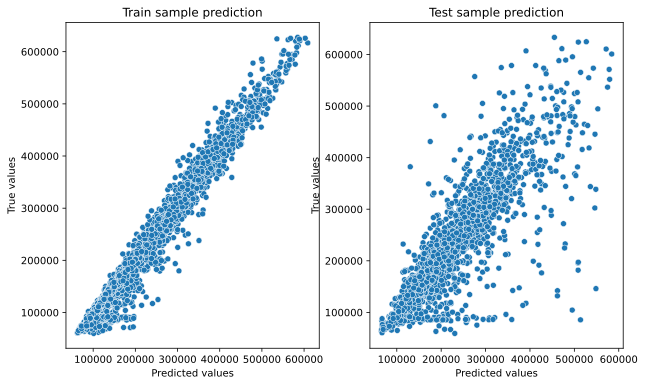

In [50]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [51]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=21))
cv_score

array([0.74244883, 0.74684599, 0.7516462 , 0.77056427, 0.8139946 ])

In [52]:
cv_score.mean()

0.7650999795326553

In [53]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.438831
13,MedPriceOneSquareMetrByDistrict,0.353485
12,MedSquareByDistrict,0.033198
2,LifeSquare,0.025679
6,HouseYear,0.020367
14,MedPriceByFloorYear,0.019919
5,HouseFloor,0.015981
4,Floor,0.015456
9,Social_2,0.013734
7,Ecology_1,0.013453


In [54]:
%%time
gb = GradientBoostingRegressor(criterion='mse',
                                     max_depth=3,
                                     min_samples_leaf=5,
                                     random_state=42,  
                                     n_estimators=500,
                                     subsample=1.0)
gb.fit(X_train, y_train)
#bagging = BaggingRegressor()

Wall time: 13.6 s


GradientBoostingRegressor(criterion='mse', min_samples_leaf=5, n_estimators=500,
                          random_state=42)

In [55]:
%%time
#params = {'n_estimators':[50, 100, 200, 400, 500], 
#          'max_depth':[3, 5, 7, 10, 12],
#          'min_samples_leaf':[5, 7, 10, 12, 15]}
#
#gs = GridSearchCV(gb, params, 
#                  scoring='r2', # метрика 
#                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
#                           random_state=21, 
#                           shuffle=True),
#                  n_jobs=-1
 #                 )
#gs.fit(X_train, y_train)

Wall time: 0 ns


In [56]:
#res = pd.DataFrame(gs.cv_results_)
#res.head(10)

Train R2:	0.876
Test R2:	0.717


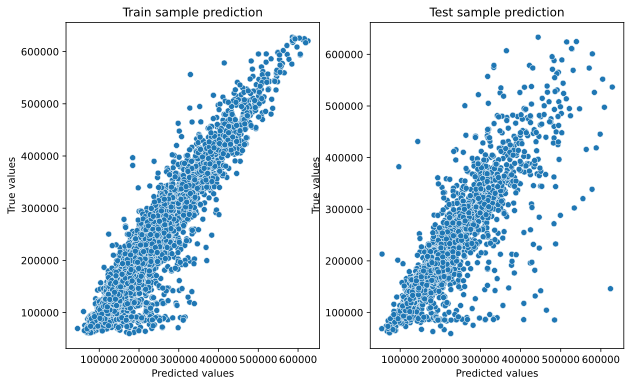

In [57]:
y_train_preds = gb.predict(X_train)
y_test_preds = gb.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [58]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.450237
13,MedPriceOneSquareMetrByDistrict,0.396182
0,Rooms,0.027453
14,MedPriceByFloorYear,0.021619
12,MedSquareByDistrict,0.020712
8,Social_1,0.012475
2,LifeSquare,0.011982
5,HouseFloor,0.011574
6,HouseYear,0.010031
7,Ecology_1,0.007800


In [ ]:
cv_score = cross_val_score(gb, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=21))
cv_score

In [ ]:
cv_score.mean()

In [ ]:
%%time
#params = {'n_estimators':[10, 20, 30, 40], 
#          'max_samples':[0.8, 0.9, 1.0],
#          'max_features':[0.8, 0.9, 1.0]}
#
#gs = GridSearchCV(br, params, 
#                  scoring='r2', # метрика 
                  #cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                 #          random_state=21, 
                  #         shuffle=True),
#                  n_jobs=-1
#                  )
#gs.fit(X_train, y_train)

In [ ]:
#res = pd.DataFrame(gs.cv_results_)
#res.sort_values(['rank_test_score'])

In [ ]:
%%time
br = BaggingRegressor(base_estimator=gb,
                      n_estimators=40,
                      max_samples=1.0,
                      max_features=0.9,
                      random_state=42,
                      n_jobs=-1)

br.fit(X_train, y_train)

In [ ]:
y_train_preds = br.predict(X_train)
y_test_preds = br.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [ ]:
cv_score = cross_val_score(br, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=21))
cv_score

In [ ]:
cv_score.mean()

In [ ]:
#abr = AdaBoostRegressor(base_estimator=br, random_state=12, n_estimators=10)

#abr.fit(X_train, y_train)

In [ ]:
#y_train_preds = abr.predict(X_train)
#y_test_preds = abr.predict(X_valid)

#evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [ ]:
#cv_score = cross_val_score(abr, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=21))
#cv_score

In [ ]:
#cv_score.mean()

In [ ]:
"""
estimators = [
    ('lr', RidgeCV()),
    ('svr', LinearSVR(random_state=42)),
    ('rf', rf_model),
    ('gb', gb),
    ('br', br),
    ('abr', abr)]
sr = StackingRegressor(estimators=estimators, final_estimator=GradientBoostingRegressor(criterion='mse',
                                     max_depth=3,
                                     min_samples_leaf=5,
                                     random_state=42,  
                                     n_estimators=500,
                                     subsample=1.0), passthrough=True, n_jobs=-1)

sr.fit(X_train, y_train)"""

In [ ]:
#y_train_preds = sr.predict(X_train)
#y_test_preds = sr.predict(X_valid)

#evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [ ]:
#cv_score = cross_val_score(sr, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=21))
#cv_score

In [ ]:
#cv_score.mean()

### 8. Прогнозирование на тестовом датасете

In [ ]:
test_df

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit.head()

In [ ]:
predictions = br.predict(test_df)
predictions


In [ ]:
submit['Price'] = predictions
submit.head()

In [ ]:
submit.to_csv('br_4_submit.csv', index=False)